In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow.keras.backend as K

# Convolution Example
For this example we are going to explore convolutions using the backend functions found in Keras. Note usually you will not do this because when you make a model you will use the ```keras.layers.Conv2D``` layer and not the backend function ```keras.backend.conv2d```.

To start we make a 5x5 image with 1 batch dimension (first dimension) and 1 channel dimension (last dimension)

In [2]:
image = np.array([[0, 0, 0, 0, 1],
                 [0, 0, 0, 1, 1],
                 [0, 0, 1, 1, 1],
                 [0, 0, 1, 1, 1],
                 [0, 0, 1, 1, 1]])
image = image[None,:,:,None]
image.shape

(1, 5, 5, 1)

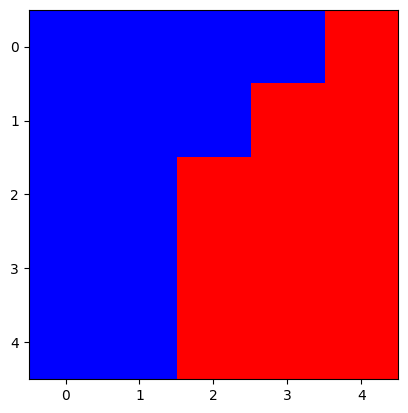

In [3]:
plt.imshow(image[0, ..., 0], cmap='bwr', interpolation='nearest')
plt.show()

Make a kernel or a filter to apply to the image above. In this case we are making a filter which will look for vertical lines (changes in the x direction). The kernel we are using is from https://en.wikipedia.org/wiki/Sobel_operator

In [4]:
kernel = np.array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])
kernel = kernel[..., None, None]
kernel.shape

(3, 3, 1, 1)

We had to pad the dimensions weird so that keras will accept it later

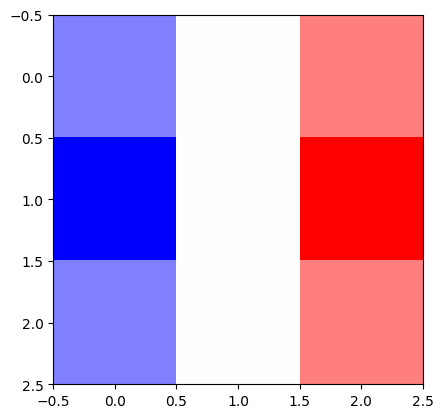

In [5]:
plt.imshow(kernel[...,0,0], cmap='bwr', interpolation='nearest')
plt.show()

Now we will make the symbolic keras tensors and function to do our convolution. Note I have included all the inputs so they are more clearly defined. 

In [6]:
imageK = keras.Input(batch_shape=(None, 5, 5, 1))
# shape = (batch_size, height or rows, width or columns, channels)

kernelK = keras.Input(batch_shape=(3, 3, 1, 1))
# shape = (height or rows, width or columns, 
#          input channels, output channels or number of filters)

output_imageK = K.conv2d(x=imageK, 
                        kernel=kernelK, 
                        data_format='channels_last',
                        strides=(1, 1),
                        padding='valid',
                        dilation_rate=(1, 1)
)

output_func = K.function(inputs=[imageK, kernelK], outputs=[output_imageK])

Now lets see what the symbolic tensors we made turned out to be. Note we defined the shape of two of these but the last one is interesting. 

In [7]:
imageK

<KerasTensor: shape=(None, 5, 5, 1) dtype=float32 (created by layer 'input_1')>

In [8]:
kernelK

<KerasTensor: shape=(3, 3, 1, 1) dtype=float32 (created by layer 'input_2')>

In [9]:
output_imageK

<KerasTensor: shape=(None, 3, 3, 1) dtype=float32 (created by layer 'tf.compat.v1.nn.convolution')>

Our output image is a (?, 3, 3, 1) which is (batch_size, width, height, channels).

Next we will put our numpy arrays through the function we made to get the output image

In [10]:
output_image = output_func([image, kernel])[0]
output_image.shape

(1, 3, 3, 1)

As expected our ? dimension turned into a 1 because our input had 1 sample (batch size of 1)

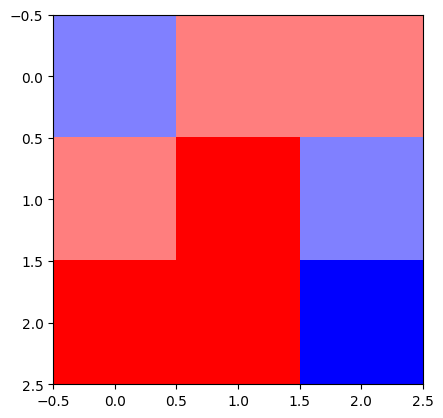

In [11]:
plt.imshow(output_image[0,...,0], cmap='bwr', interpolation='nearest')
plt.show()

In [12]:
output_image[..., 0]

array([[[1., 3., 3.],
        [3., 4., 1.],
        [4., 4., 0.]]], dtype=float32)

See how our detector sorta honed in on the bottom cliff in our image. 

Notice that our new image is smaller why is that?

Well because every time we do a convolution the new shapes are determined by a few variables namely:
Original image size $I_n$
Kernel size $F_n$
Stride length $S_n$
Pad size $P_n$
Dilation rate $D_n$
where $n$ refers to the dimension. In our case we have two dimensions to work with, height and width.

Thus the output image size is
$$ F_n^* = F_n +(F_n-1)(D_n -1)$$ 
$$ O_n = \textrm{ceil}\left( \frac{I_n - F_n^* + 2P_n}{S_n} +1 \right)$$

We know where all these come from in the function calls except pad size. We know we gave the argument ```padding='valid'``` but how does this relate to the pad size. Well padding valid means we only do filter image convolutions that overlap without the filter going off the edge. If we wanted to so ```padding='same'``` we would want to do some filter/image convolutions where the filter went off the edge of the image. In doing so we would need to pad the image. Thus padding refers to how much we pad the image. For simplicity the above equation simplifies when we fix the padding:

$$ O_n =
\begin{cases}
\textrm{ceil} \left( \frac{I_n}{S_n} \right), \textrm{same}\\
\textrm{ceil} \left( \frac{I_n - (F_n-1)D_n}{S_n} \right), \textrm{valid}
\end{cases} $$


plugging in our numbers we get:
$$ O_n = \textrm{ceil} \left( \frac{5 - (3-1)1}{1} \right), $$
$$ O_n = 3 $$

Note that it is impossible to get a fractional answer even if we our strides are more than one because the ```ceil``` function only returns integers. 

## Same Padding
Now lets change our example to show same padding. This should make an output image with equal length and width compared to our input image.

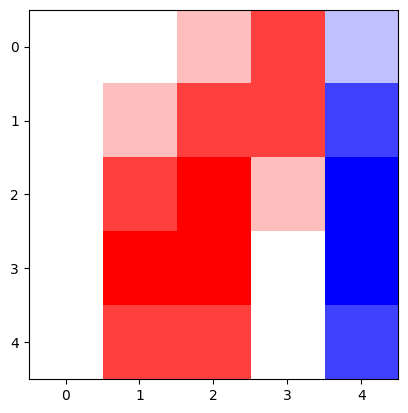

In [13]:
imageK = keras.Input(batch_shape=(None, 5, 5, 1))
# shape = (batch_size, height or rows, width or columns, channels)

kernelK = keras.Input(batch_shape=(3, 3, 1, 1))
# shape = (height or rows, width or columns, 
#          input channels, output channels or number of filters)

output_imageK = K.conv2d(x=imageK, 
                        kernel=kernelK, 
                        data_format='channels_last',
                        strides=(1, 1),
                        padding='same',
                        dilation_rate=(1, 1)
)

output_func = K.function(inputs=[imageK, kernelK], outputs=[output_imageK])
output_image = output_func([image, kernel])[0]
plt.imshow(output_image[0,...,0], cmap='bwr', interpolation='nearest')
plt.show()

As we expected we got a `5x5` image out. Now we can see the basic types of padding, however we still have not gone over the effects of strides and dilation.

## Strides
Strides will slide our filter over by different numbers of pixels. The default is 1 which means slide the filter one pixel over. If we changed that to 2 we would slide our filter over 2 pixels each time we recomputed a new convolution. This will reduce the size of our output image as shown in the equations above.

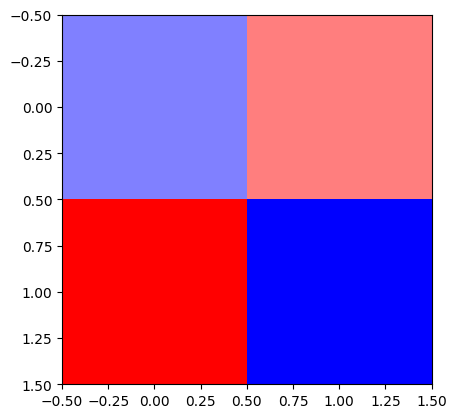

In [14]:
imageK = keras.Input(batch_shape=(None, 5, 5, 1))
# shape = (batch_size, height or rows, width or columns, channels)

kernelK = keras.Input(batch_shape=(3, 3, 1, 1))
# shape = (height or rows, width or columns, 
#          input channels, output channels or number of filters)

output_imageK = K.conv2d(x=imageK, 
                        kernel=kernelK, 
                        data_format='channels_last',
                        strides=(2, 2),
                        padding='valid',
                        dilation_rate=(1, 1)
)

output_func = K.function(inputs=[imageK, kernelK], outputs=[output_imageK])
output_image = output_func([image, kernel])[0]
plt.imshow(output_image[0,...,0], cmap='bwr', interpolation='nearest')
plt.show()

Note that our output image size has shrunk to a `2x2` because we did less works because we were skipping across our image

## Dilation
Dilation will artificially increase our filter size. As shown in the first equation $F_n^* $ is the new size of our filter due to the dilation. think of dilaiton as adding spaces between each adjacent pixel of the original filter.

Lets look at a dilation example. Here we use a dilation factor of 2 on our original kernel. Note the black is technically 0 but we will color it black to understand that those zeros are due to the dilation and not the original kernel

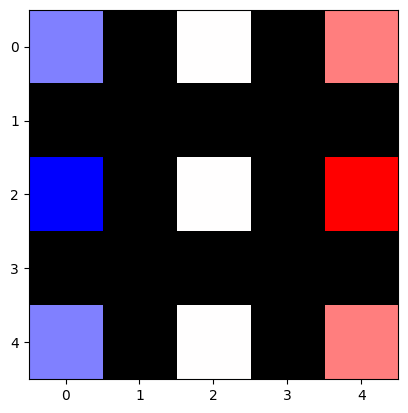

In [15]:
import matplotlib

dilation_rate = 2
f_star = 3 + (3 - 1) * (dilation_rate - 1)
dilated_kernel = np.zeros(shape=(f_star, f_star, 1, 1))
dilated_kernel[...] = np.nan

cmap = matplotlib.cm.bwr.copy()
cmap.set_bad('black',1.)

for x in range(3):
    for y in range(3):
        dilated_kernel[dilation_rate * x, dilation_rate * y, ...] = kernel[x, y, ...]
plt.imshow(dilated_kernel[..., 0, 0], cmap=cmap, interpolation='nearest')
plt.show()

So lets use this in an example

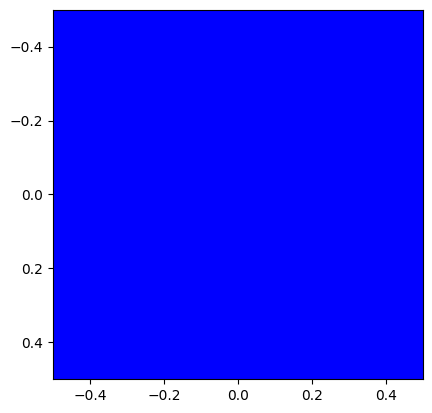

In [16]:
imageK = keras.Input(batch_shape=(None, 5, 5, 1))
# shape = (batch_size, height or rows, width or columns, channels)

kernelK = keras.Input(batch_shape=(3, 3, 1, 1))
# shape = (height or rows, width or columns, 
#          input channels, output channels or number of filters)

output_imageK = K.conv2d(x=imageK, 
                        kernel=kernelK, 
                        data_format='channels_last',
                        strides=(1, 1),
                        padding='valid',
                        dilation_rate=(2, 2)
)

output_func = K.function(inputs=[imageK, kernelK], outputs=[output_imageK])
output_image = output_func([image, kernel])[0]
plt.imshow(output_image[0,...,0], cmap='bwr', interpolation='nearest')
plt.show()

As expected if you look at our new dilated kernel it is `5x5` which means there is only one valid convolution to do which makes one output pixel.

## Real input Image Example
So now lets do a real example with larger dimensions to showcase the Sobel filter. We will borrow the image from the  [Wikipedia Sobel page](https://en.wikipedia.org/wiki/Sobel_operator) to do this.

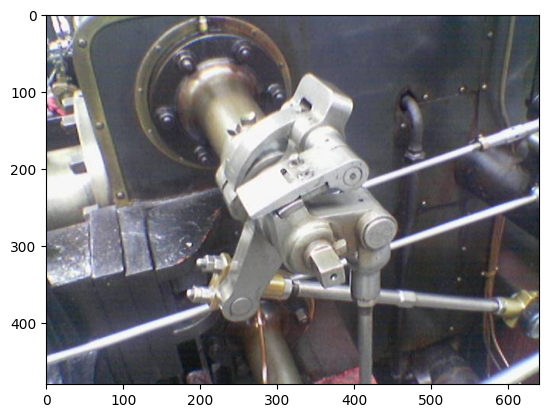

In [17]:
import scipy
valve = plt.imread('Valve_original_(1).PNG')
valve = valve[None]
plt.imshow(valve[0])
plt.show()

And the shape of this image is:

In [18]:
valve.shape

(1, 480, 640, 3)

Next we will build two Sobel filters for each direction. I will also need to expand the 2D filter to a 4D tensor of kernels.

Note I need to make a filter for each input dimension (RGB) but I really just want the same filter so I will repeat the filter in that dimension to account for the 3 input channels. 

In [19]:
sobel_x = np.array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])
sobel_y = np.array(sobel_x).transpose()

# make our kernel 4D
sobel_x = sobel_x[..., None, None]
# repeat the input channels axis to account for 3 input channels
sobel_x = np.repeat(a=sobel_x, repeats=3, axis=-2)

# repeat for other kernel
sobel_y = sobel_y[..., None, None]
sobel_y = np.repeat(a=sobel_y, repeats=3, axis=-2)

# print shape of kernel for sanity check
sobel_x.shape

(3, 3, 3, 1)

Next we will print the 2D version of our two kernels to check we did this correct

In [20]:
sobel_x[..., 0, 0]

array([[-1,  0,  1],
       [-2,  0,  2],
       [-1,  0,  1]])

In [21]:
sobel_y[...,0, 0]

array([[-1, -2, -1],
       [ 0,  0,  0],
       [ 1,  2,  1]])

Next we make a symbolic function to take our valve image and kernels and output a combined image. The combined image is determined by squaring the output of each convolution and summing then taking a square root.

In [22]:
valveK = keras.Input(batch_shape=(None, None, None, 3))
# shape = (batch_size, height or rows, width or columns, channels)

sobelxK = keras.Input(batch_shape=sobel_x.shape)
# shape = (height or rows, width or columns, input channels, output channels or number of filters)

sobelyK = keras.Input(batch_shape=sobel_y.shape)
# shape = (height or rows, width or columns, input channels, output channels or number of filters)

output_imagexK = K.conv2d(x=valveK, 
                        kernel=sobelxK, 
                        data_format='channels_last',
                        strides=(1, 1),
                        padding='valid',
                        dilation_rate=(1, 1)
)

output_imageyK = K.conv2d(x=valveK, 
                        kernel=sobelyK, 
                        data_format='channels_last',
                        strides=(1, 1),
                        padding='valid',
                        dilation_rate=(1, 1)
)

combined_imageK = K.sqrt(K.square(output_imagexK) + K.square(output_imageyK))

output_func2 = K.function(inputs=[valveK, sobelxK, sobelyK], outputs=[combined_imageK])

For a sanity check lets see what TensorFlow thinks our tensor shapes will be

In [23]:
valveK

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_9')>

In [24]:
output_imagexK

<KerasTensor: shape=(None, None, None, 1) dtype=float32 (created by layer 'tf.compat.v1.nn.convolution_3')>

In [25]:
sobelxK

<KerasTensor: shape=(3, 3, 3, 1) dtype=float32 (created by layer 'input_10')>

In [26]:
combined_imageK

<KerasTensor: shape=(None, None, None, 1) dtype=float32 (created by layer 'tf.math.sqrt')>

Now we will pass our actual numpy arrays to the function we made to get an acutal output image

In [27]:
output_image2 = output_func2([valve, sobel_x, sobel_y])[0]
output_image2.shape

(1, 478, 638, 1)

Now plot that image next to the original

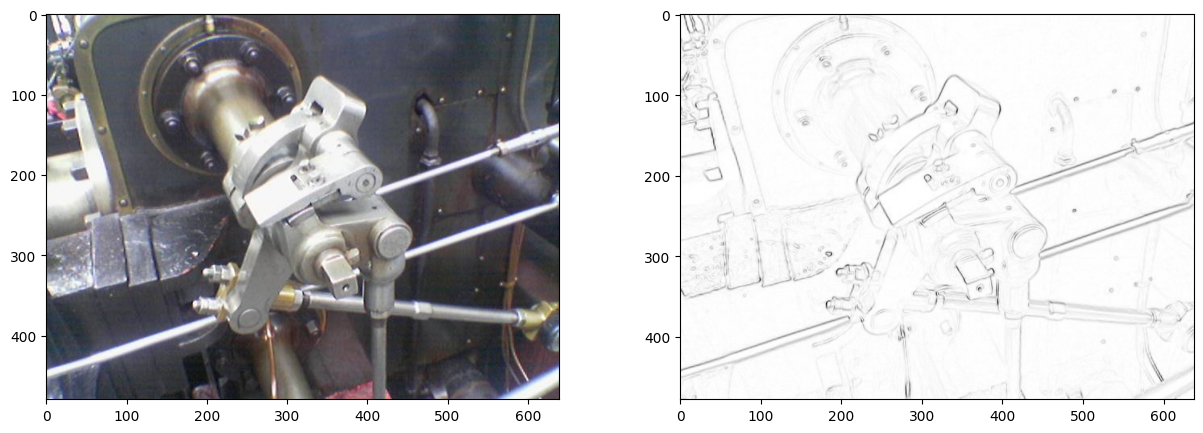

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.imshow(valve[0])

plt.subplot(1, 2, 2)
plt.imshow(output_image2[0, ..., 0], cmap='Greys')
plt.show()

Next we print the shapes of our original and final image to so some shape calculation

In [29]:
valve.shape

(1, 480, 640, 3)

In [30]:
output_image2.shape

(1, 478, 638, 1)

Lets do our padding math with this new dimensions:

$$ O_n =\textrm{ceil} \left( \frac{I_n - (F_n-1)D_n}{S_n} \right)$$
Now apply the equation to our first dimension:
$$ O_1 = \textrm{ceil} \left( \frac{480 - (3-1)1}{1} \right)$$
$$ O_1 = 478 $$
And now the next dimension:
$$ O_2 = \textrm{ceil} \left( \frac{640 - (3-1)1}{1} \right)$$
$$ O_2 = 638 $$

## Note on this example
While in this example we use a Sobel filter, in general the ANN will determine the filters (kernels) through the optimization process. For each layer the ANN will learn a kernel for each input channel to match to each output channel. Thus the total number of kernels to be learned by an ANN is input channels times output channels. 

Remember the ANN will do convolutions over each input channel equal to the number of output channels. Then the output channel result images are summed to make the desired number of output channels.

This can make a very large number of weights for all these filters. For example if we have 3 input channels, 10 output channels and are using 10x10 kernels then we have
$3 \times 10 \times 10 \times 10 = 3000$ weight parameters. To compare, in a dense layer if the input size was 3 and we had output 10 we would only have $3 \times 10 = 30$ weights.